## Time-Series with RNN:

In [7]:
# !pip install tf-nightly-2.0-preview

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-dev20191002


## Plotting the Series:

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

## Creating Windowed Dataset:

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

## Building the Model:

In [4]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                         input_shape=[None]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0) # helps training faster
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
                lambda epoch: 1e-8 * 10 * (epoch/20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

# compile the model 
model.compile(loss=tf.keras.losses.Huber(),
             optimzer=optimizer, metrics=['mae'])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 229ms/step - loss: 195.7794 - mae: 196.2234
Epoch 2/100
8/8 [==============================] - 0s 26ms/step - loss: 195.8597 - mae: 196.2228
Epoch 3/100
8/8 [==============================] - 0s 24ms/step - loss: 195.9993 - mae: 196.2202
Epoch 4/100
8/8 [==============================] - 0s 24ms/step - loss: 195.6139 - mae: 196.2151
Epoch 5/100
8/8 [==============================] - 0s 25ms/step - loss: 195.6361 - mae: 196.2081
Epoch 6/100
8/8 [==============================] - 0s 24ms/step - loss: 195.9910 - mae: 196.1991
Epoch 7/100
8/8 [==============================] - 0s 25ms/step - loss: 195.6370 - mae: 196.1879
Epoch 8/100
8/8 [==============================] - 0s 27ms/step - loss: 195.5220 - mae: 196.1755
Epoch 9/100
8/8 [==============================] - 0s 27ms/step - loss: 195.4268 - mae: 196.1611
Epoch 10/100
8/8 [==============================] - 0s 25ms/step - loss: 195.8441 - mae: 196.1443
Epoch 11/100
8/8 [==========

8/8 [==============================] - 0s 27ms/step - loss: 188.8492 - mae: 189.3561
Epoch 85/100
8/8 [==============================] - 0s 31ms/step - loss: 188.7414 - mae: 189.1884
Epoch 86/100
8/8 [==============================] - 0s 25ms/step - loss: 188.5421 - mae: 189.0190
Epoch 87/100
8/8 [==============================] - 0s 24ms/step - loss: 188.3594 - mae: 188.8475
Epoch 88/100
8/8 [==============================] - 0s 33ms/step - loss: 188.0576 - mae: 188.6740
Epoch 89/100
8/8 [==============================] - 0s 25ms/step - loss: 188.0079 - mae: 188.4982
Epoch 90/100
8/8 [==============================] - 0s 26ms/step - loss: 187.6919 - mae: 188.3201
Epoch 91/100
8/8 [==============================] - 0s 28ms/step - loss: 187.4851 - mae: 188.1400
Epoch 92/100
8/8 [==============================] - 0s 23ms/step - loss: 187.5036 - mae: 187.9580
Epoch 93/100
8/8 [==============================] - 0s 31ms/step - loss: 187.2836 - mae: 187.7739
Epoch 94/100
8/8 [===============

[1e-08, 0.0001, 0, 30]

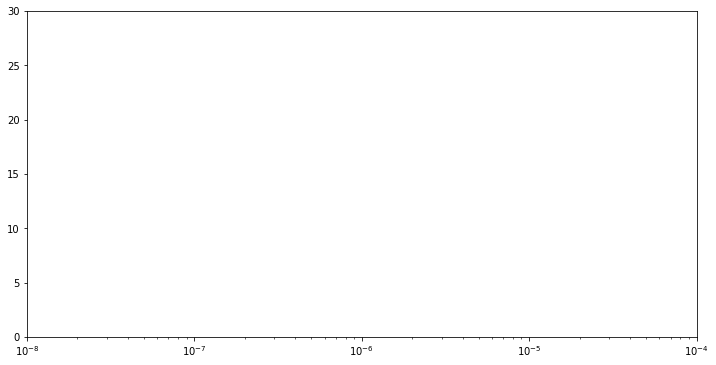

In [5]:
plt.figure(figsize=(12,6))

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

# build the model 
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                          input_shape=[None]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])


optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)

# compile the model 
model.compile(loss=tf.keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

# fit the model 
history = model.fit(dataset, epochs=400)

history 

Epoch 1/400
8/8 [==============================] - 1s 180ms/step - loss: 80.8704 - mae: 83.5782
Epoch 2/400
8/8 [==============================] - 0s 26ms/step - loss: 23.6082 - mae: 24.3853
Epoch 3/400
8/8 [==============================] - 0s 24ms/step - loss: 18.2198 - mae: 18.7074
Epoch 4/400
8/8 [==============================] - 0s 24ms/step - loss: 14.1505 - mae: 14.6785
Epoch 5/400
8/8 [==============================] - 0s 24ms/step - loss: 10.7214 - mae: 11.2667
Epoch 6/400
8/8 [==============================] - 0s 24ms/step - loss: 12.4073 - mae: 12.5672
Epoch 7/400
8/8 [==============================] - 0s 24ms/step - loss: 12.5412 - mae: 13.0874
Epoch 8/400
8/8 [==============================] - 0s 24ms/step - loss: 11.9038 - mae: 12.4915
Epoch 9/400
8/8 [==============================] - 0s 23ms/step - loss: 14.4514 - mae: 15.1545
Epoch 10/400
8/8 [==============================] - 0s 24ms/step - loss: 21.4314 - mae: 21.9367
Epoch 11/400
8/8 [==============================

8/8 [==============================] - 0s 31ms/step - loss: 4.8836 - mae: 5.4109
Epoch 88/400
8/8 [==============================] - 0s 30ms/step - loss: 5.1746 - mae: 5.6854
Epoch 89/400
8/8 [==============================] - 0s 27ms/step - loss: 4.7971 - mae: 5.3188
Epoch 90/400
8/8 [==============================] - 0s 28ms/step - loss: 4.4439 - mae: 4.9259
Epoch 91/400
8/8 [==============================] - 0s 26ms/step - loss: 4.7532 - mae: 5.2618
Epoch 92/400
8/8 [==============================] - 0s 29ms/step - loss: 5.3443 - mae: 5.7755
Epoch 93/400
8/8 [==============================] - 0s 27ms/step - loss: 5.3844 - mae: 5.7934
Epoch 94/400
8/8 [==============================] - 0s 27ms/step - loss: 5.5509 - mae: 5.8823
Epoch 95/400
8/8 [==============================] - 0s 28ms/step - loss: 5.5352 - mae: 6.0072
Epoch 96/400
8/8 [==============================] - 0s 26ms/step - loss: 6.6327 - mae: 7.0036
Epoch 97/400
8/8 [==============================] - 0s 29ms/step - loss: 

8/8 [==============================] - 0s 33ms/step - loss: 6.9668 - mae: 7.4715
Epoch 174/400
8/8 [==============================] - 0s 25ms/step - loss: 5.1592 - mae: 5.6376
Epoch 175/400
8/8 [==============================] - 0s 26ms/step - loss: 4.5297 - mae: 5.0273
Epoch 176/400
8/8 [==============================] - 0s 30ms/step - loss: 4.6908 - mae: 5.1942
Epoch 177/400
8/8 [==============================] - 0s 26ms/step - loss: 4.3808 - mae: 4.8575
Epoch 178/400
8/8 [==============================] - 0s 27ms/step - loss: 4.5120 - mae: 5.0050
Epoch 179/400
8/8 [==============================] - 0s 25ms/step - loss: 4.7662 - mae: 5.2312
Epoch 180/400
8/8 [==============================] - 0s 29ms/step - loss: 5.0926 - mae: 5.6130
Epoch 181/400
8/8 [==============================] - 0s 25ms/step - loss: 5.7765 - mae: 6.3117
Epoch 182/400
8/8 [==============================] - 0s 29ms/step - loss: 5.3527 - mae: 5.8708
Epoch 183/400
8/8 [==============================] - 0s 25ms/ste

8/8 [==============================] - 0s 33ms/step - loss: 4.9464 - mae: 5.4461
Epoch 260/400
8/8 [==============================] - 0s 26ms/step - loss: 4.7177 - mae: 5.1978
Epoch 261/400
8/8 [==============================] - 0s 23ms/step - loss: 4.1961 - mae: 4.6600
Epoch 262/400
8/8 [==============================] - 0s 30ms/step - loss: 4.4825 - mae: 4.9099
Epoch 263/400
8/8 [==============================] - 0s 24ms/step - loss: 4.1175 - mae: 4.5939
Epoch 264/400
8/8 [==============================] - 0s 31ms/step - loss: 4.8227 - mae: 5.3081
Epoch 265/400
8/8 [==============================] - 0s 25ms/step - loss: 4.7958 - mae: 5.2661
Epoch 266/400
8/8 [==============================] - 0s 32ms/step - loss: 4.8939 - mae: 5.4023
Epoch 267/400
8/8 [==============================] - 0s 25ms/step - loss: 4.4058 - mae: 4.8991
Epoch 268/400
8/8 [==============================] - 0s 31ms/step - loss: 4.0534 - mae: 4.5454
Epoch 269/400
8/8 [==============================] - 0s 26ms/ste

8/8 [==============================] - 0s 27ms/step - loss: 5.7223 - mae: 6.2116
Epoch 346/400
8/8 [==============================] - 0s 28ms/step - loss: 4.5499 - mae: 5.0139
Epoch 347/400
8/8 [==============================] - 0s 31ms/step - loss: 4.5155 - mae: 4.9484
Epoch 348/400
8/8 [==============================] - 0s 36ms/step - loss: 5.0483 - mae: 5.4950
Epoch 349/400
8/8 [==============================] - 0s 32ms/step - loss: 4.8945 - mae: 5.3394
Epoch 350/400
8/8 [==============================] - 0s 35ms/step - loss: 4.6766 - mae: 5.1722
Epoch 351/400
8/8 [==============================] - 0s 38ms/step - loss: 4.3617 - mae: 4.8086
Epoch 352/400
8/8 [==============================] - 0s 34ms/step - loss: 4.3407 - mae: 4.7986
Epoch 353/400
8/8 [==============================] - 0s 39ms/step - loss: 4.2397 - mae: 4.7185
Epoch 354/400
8/8 [==============================] - 0s 29ms/step - loss: 4.2131 - mae: 4.6505
Epoch 355/400
8/8 [==============================] - 0s 36ms/ste

## Making Forecast:

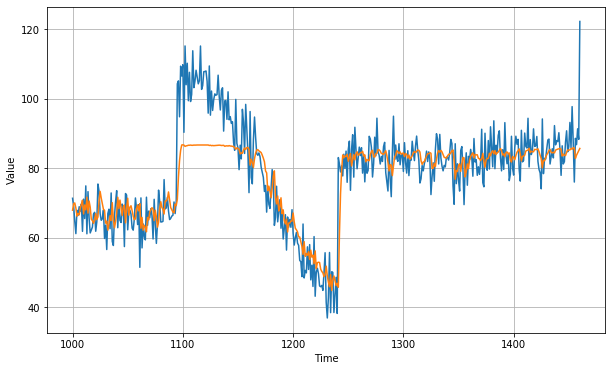

In [7]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
    
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10,6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [8]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.0195117

<Figure size 432x288 with 0 Axes>

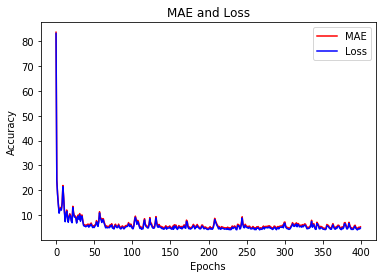

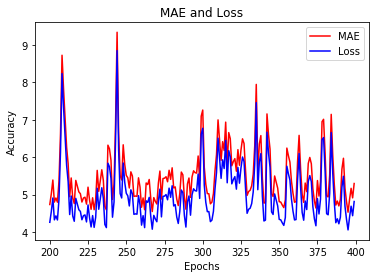

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()